In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

# California Housing

Este es un [dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) muy popular que vamos a leer desde **Scikit-Learn**.

Se requiere construir un modelo de regresión que nos permita predecir el valor medio de las casas en distintos distritos de California (medido en cientos de miles de dólares, es decir, $100,000). Este conjunto de datos proviene del censo de EE. UU. de 1990, donde cada observación corresponde a un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (típicamente con una población de entre 600 y 3,000 personas).


Un hogar es un grupo de personas que residen dentro de una misma vivienda. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores altos en bloques con pocos hogares y muchas viviendas vacías.

Los atributos, en el orden en que se guardaron en el dataset, son:

- `MedInc`: Ingreso medio del bloque
- `HouseAge`: Edad mediana de las viviendas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar
- `AveBedrms`: Número promedio de dormitorios por hogar
- `Population`: Población del bloque
- `AveOccup`: Número promedio de personas por hogar
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

In [2]:
# Lectura del dataset
california_housing = fetch_california_housing()

# Obtenemos los atributos y el target:
X = california_housing.data
y = california_housing.target

# Transformamos los datos a estructuras de Pandas:
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos X e y; esto es útil para generar el mapa de calor de correlaciones
df_california = pd.concat([X, y], axis=1)

In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [5]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


División en entrenamiento y evaluación

In [12]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=california_housing['feature_names'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

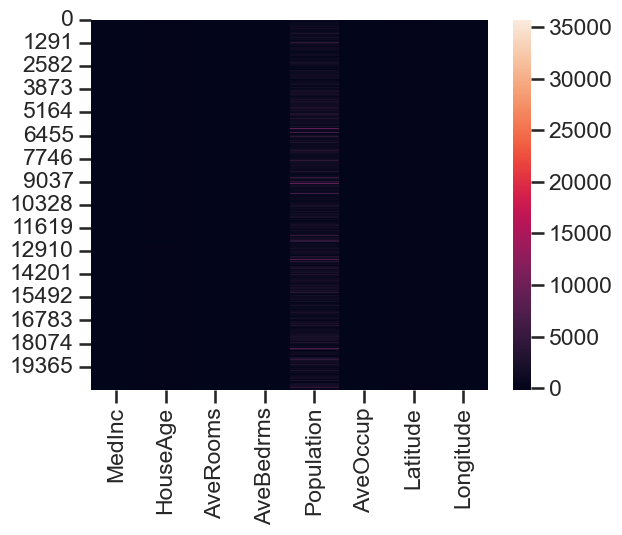

In [8]:
# realizamos un heatmap sobre la matriz X resultante, population esta fuera de escala. 
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(X)
plt.show()

In [9]:
# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

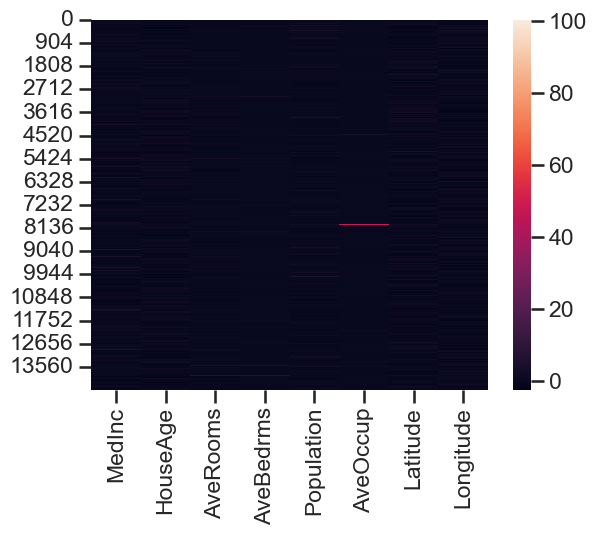

In [10]:
# realizamos un heatmap sobre la matriz X resultante, datos mas escalados ahora
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(X_train_scaled)
plt.show()

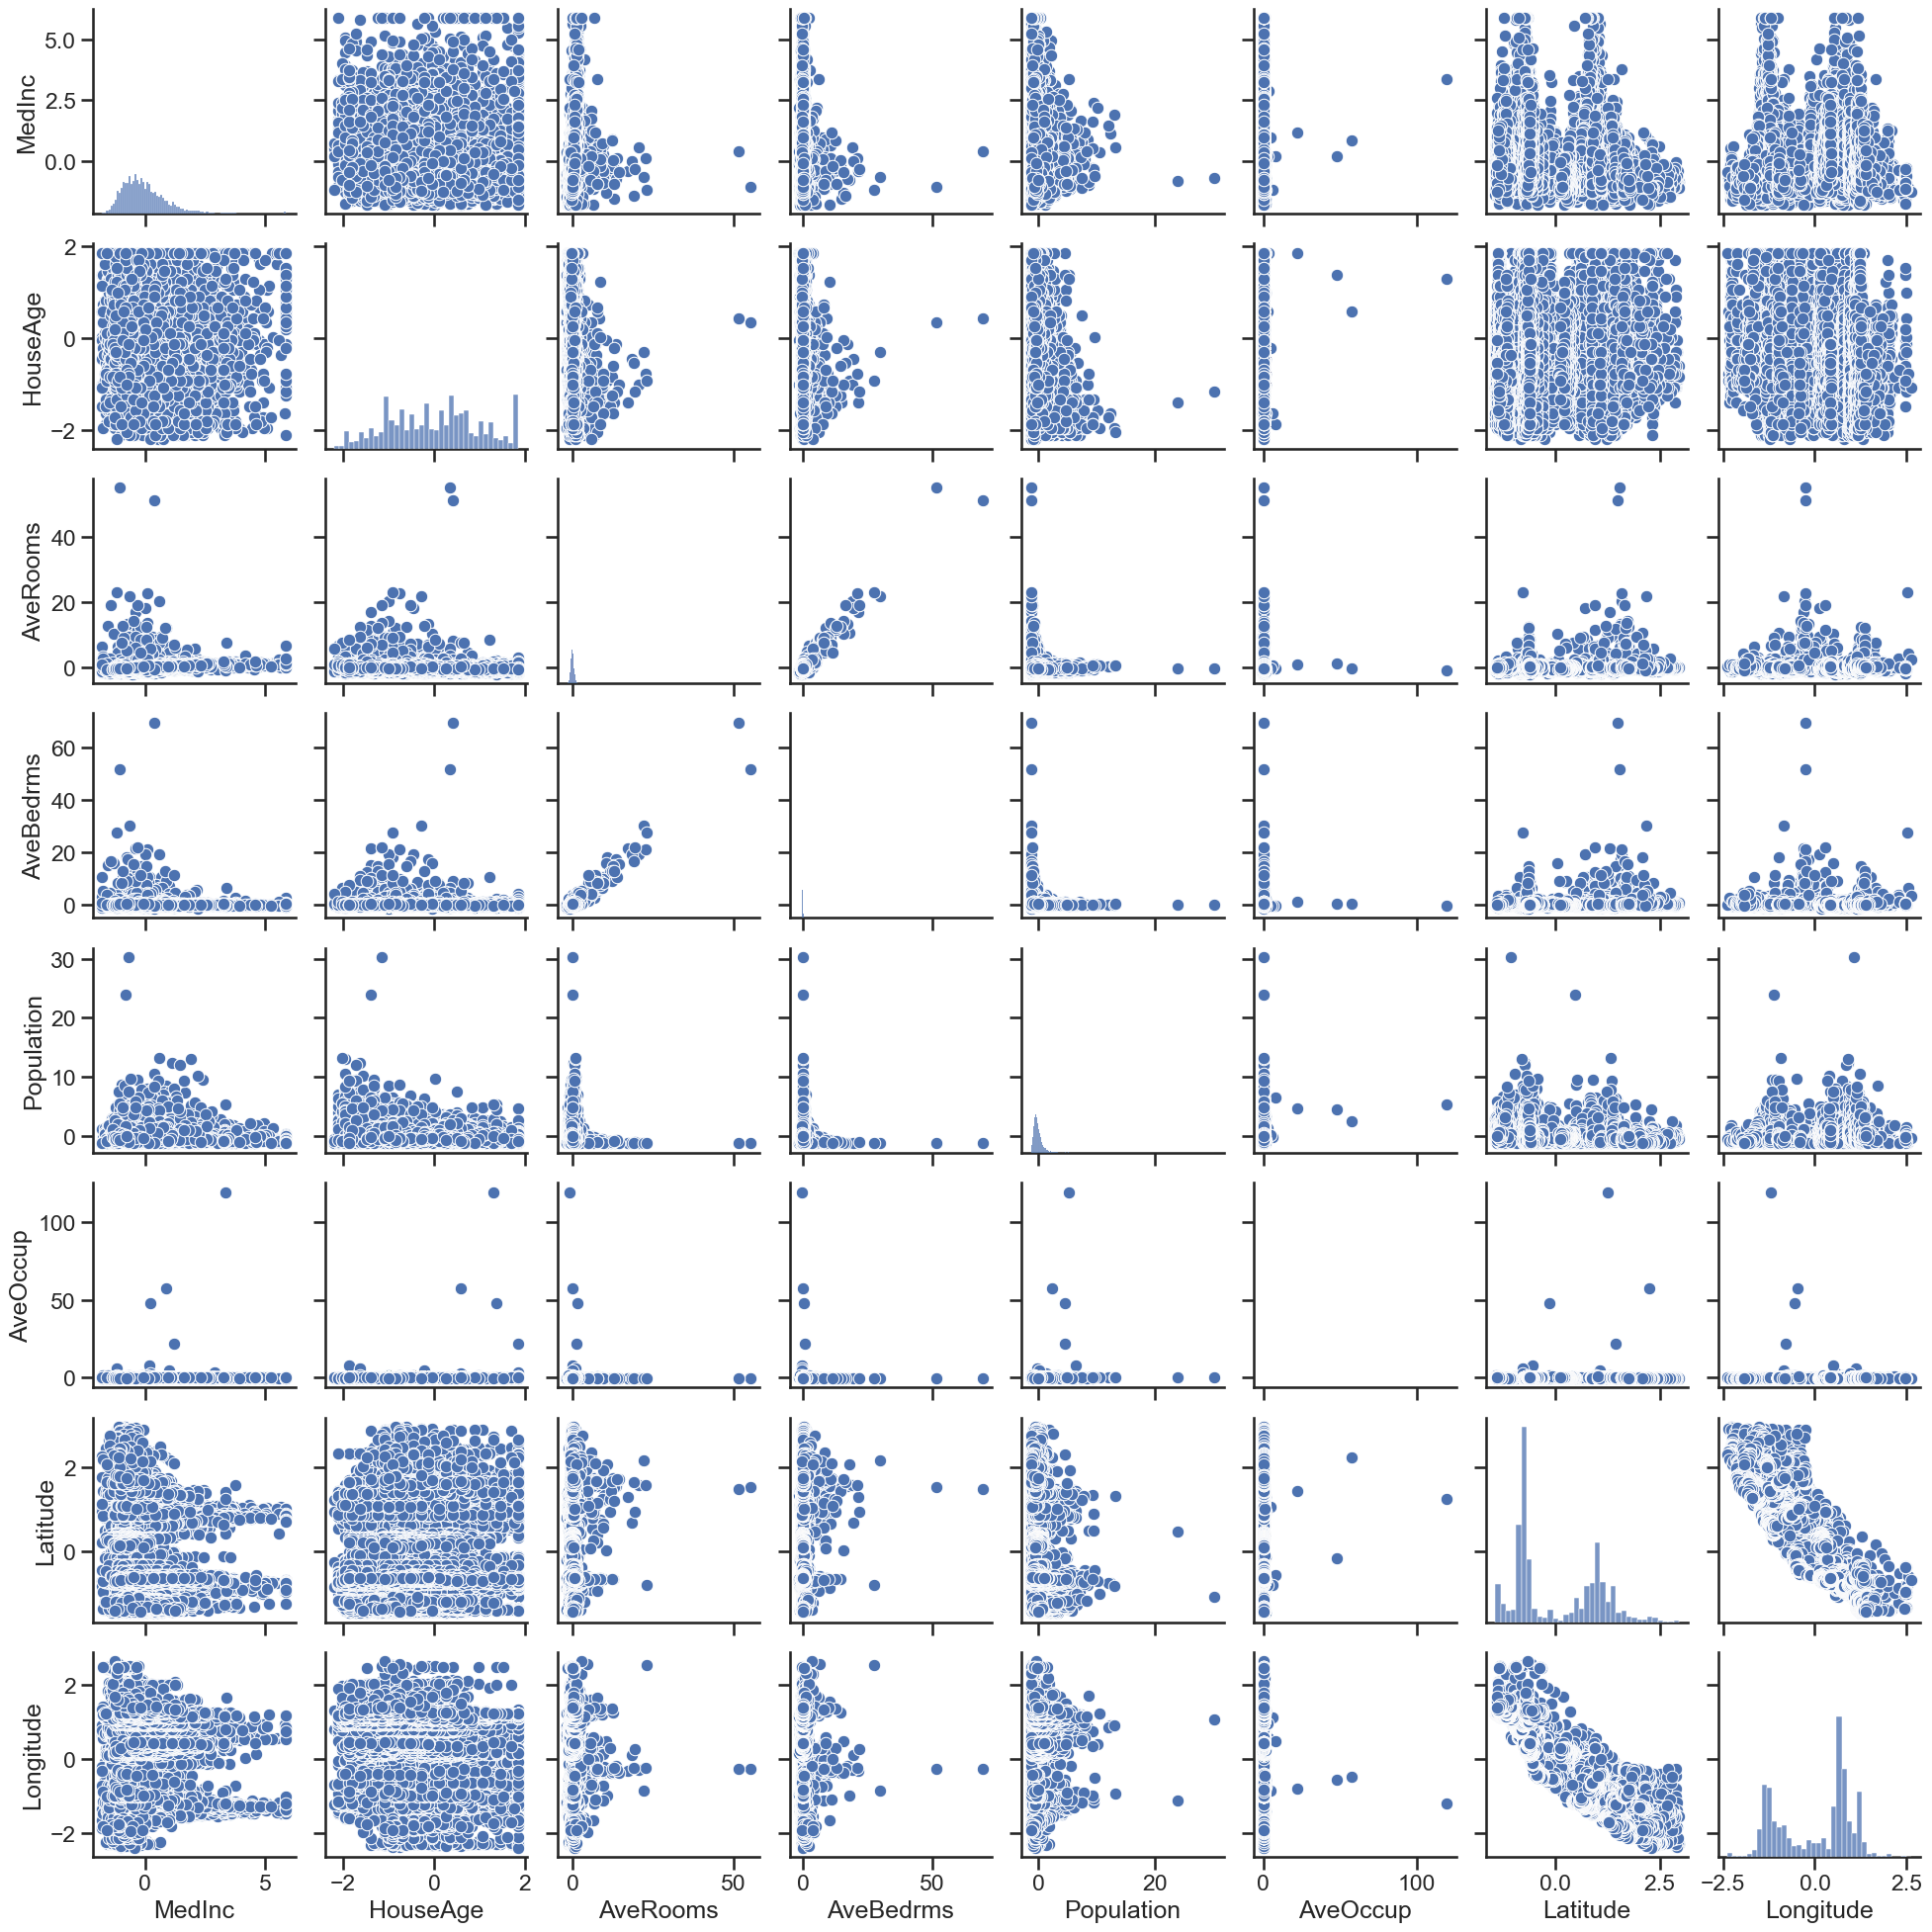

In [13]:
# pairplot 
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.pairplot(X_scaled)
plt.show()

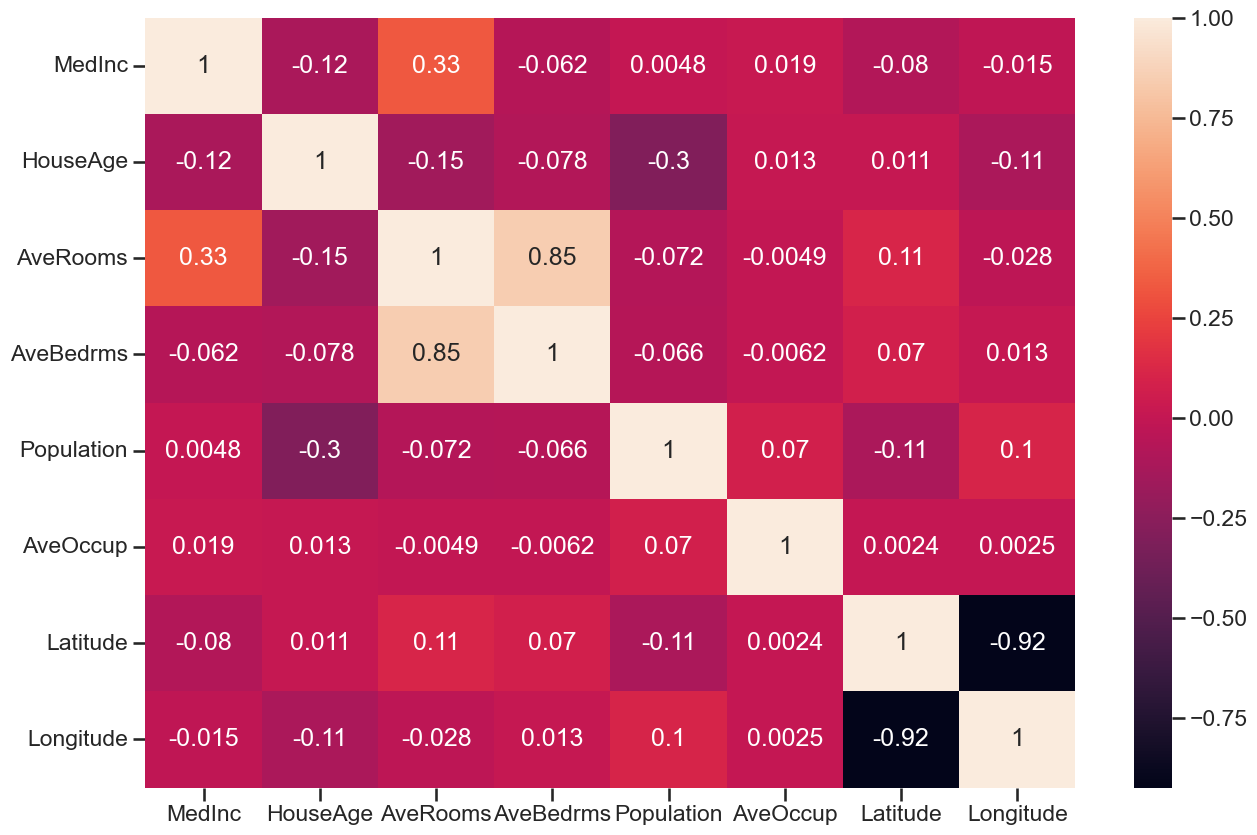

In [16]:
plt.figure(figsize=(15, 10))
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(X_scaled.corr(),annot=True)
plt.show()

Ejemplo de validación cruzada

- Usamos el método de 5 folds
- Utilizamos el MSE. [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) devuelve el valor negativo por cuestiones de compatibilidad con otras funciones de la biblioteca.

In [9]:
# Creamos un modelo
alpha = 1.0
ridge_model = Ridge(alpha=alpha)

cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)

# Este cálculo nos devuelve el valor del MSE para cada uno de los folds.
cv

array([-0.54786366, -0.5008472 , -0.52047089, -0.51611229, -0.54882174])

Podemos obtener la media y el desvío estándar de los errores:

In [10]:
print(f"La media del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha={alpha} es {(-1)*cv.mean()}")
print(f"El desvío estándar del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha={alpha} es {cv.std()}")

La media del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha=1.0 es 0.5268231539349313
El desvío estándar del MSE en validación cruzada (5-fold) para la regresión Ridge con alpha=1.0 es 0.01874280974833451


### Búsqueda de hiperparámetros

Aquí generamos varios valores de alpha para la búsqueda solicitada en el TP:

In [11]:
alpha_values = np.linspace(0, 12.5, 100)
alpha_values

array([ 0.        ,  0.12626263,  0.25252525,  0.37878788,  0.50505051,
        0.63131313,  0.75757576,  0.88383838,  1.01010101,  1.13636364,
        1.26262626,  1.38888889,  1.51515152,  1.64141414,  1.76767677,
        1.89393939,  2.02020202,  2.14646465,  2.27272727,  2.3989899 ,
        2.52525253,  2.65151515,  2.77777778,  2.9040404 ,  3.03030303,
        3.15656566,  3.28282828,  3.40909091,  3.53535354,  3.66161616,
        3.78787879,  3.91414141,  4.04040404,  4.16666667,  4.29292929,
        4.41919192,  4.54545455,  4.67171717,  4.7979798 ,  4.92424242,
        5.05050505,  5.17676768,  5.3030303 ,  5.42929293,  5.55555556,
        5.68181818,  5.80808081,  5.93434343,  6.06060606,  6.18686869,
        6.31313131,  6.43939394,  6.56565657,  6.69191919,  6.81818182,
        6.94444444,  7.07070707,  7.1969697 ,  7.32323232,  7.44949495,
        7.57575758,  7.7020202 ,  7.82828283,  7.95454545,  8.08080808,
        8.20707071,  8.33333333,  8.45959596,  8.58585859,  8.71